# Detección de transacciones bancarias fraudulentas

### Descripción
The datasets contains transactions made by credit cards in September 2013 by european cardholders. 
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

### Descarga de los ficheros de datos
https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

### Referencias adicionales sobre el conjunto de datos
_The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection.
More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project._

<h3 data-start="0" data-end="403"><em><strong>Objetivo:</strong></em></h3>
<p data-start="0" data-end="403">Desarrollar un modelo de red neuronal artificial capaz de detectar transacciones fraudulentas en tarjetas de cr&eacute;dito, utilizando un conjunto de datos altamente desbalanceado, donde las variables predictoras han sido transformadas mediante PCA. El modelo buscar&aacute; maximizar la detecci&oacute;n de fraudes (clase 1) manteniendo un alto desempe&ntilde;o general, a pesar del bajo porcentaje de casos positivos.</p>

### Imports

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn import metrics
import numpy as np
import random
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm
from sklearn.metrics import f1_score , classification_report
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score


### Semillas

In [18]:
# 1. Semilla para Python
random.seed(42)
# 2. Semilla para NumPy
np.random.seed(42)
# 3. Semilla para TensorFlow
tf.random.set_seed(42)

### Funciones auxiliares

In [19]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [20]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [21]:
def find_best_threshold(y_true, y_probs, metric=f1_score):
    best_threshold = 0.5
    best_metric = 0

    thresholds = np.linspace(0, 1, 100)
    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        score = metric(y_true, y_pred)
        if score > best_metric:
            best_metric = score
            best_threshold = t

    return best_threshold, best_metric

## 1. Lectura del conjunto de datos

In [22]:
df = pd.read_csv("creditcard.csv")

## 2. Visualización del conjunto de datos

In [23]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [24]:
print("Número de características:", len(df.columns))
print("Longitud del conjunto de datos:", len(df))

Número de características: 31
Longitud del conjunto de datos: 284807


<p><em><strong>Comentario:</strong> El dataset por motivos de seguridad se le ha aplicado el algoritmo PCA, ya est&aacute; normalizado con excepci&oacute;n de dos columnas que son tiempo y Amount.&nbsp;</em></p>

In [25]:
# 492 transacciones fraudulentas, 284315 transacciones legitimas
# El conjunto de datos se encuntra desequilabrado
df["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

<p><em><strong>Comentario:</strong> Las clases est&aacute;n sumamente desbalanceadas, la clase 1 es el 0.1730 % del Dataset, por lo cual probablemente usemos un muestreo estratificado m&aacute;s adelante.</em></p>

In [26]:
# Visualizamos los tipos de cada uno de los atributos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [27]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [28]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


<p><em><strong>Comentario:</strong> No hay valores nulos o faltantes, y todas las variables con las excepciones mencionadas m&aacute;s arriba est&aacute;n en los mismos rangos.&nbsp;</em></p>

### Visualizaciones Preliminares

C:\Users\luise\AppData\Local\Temp\ipykernel_11940\2808278915.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\luise\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


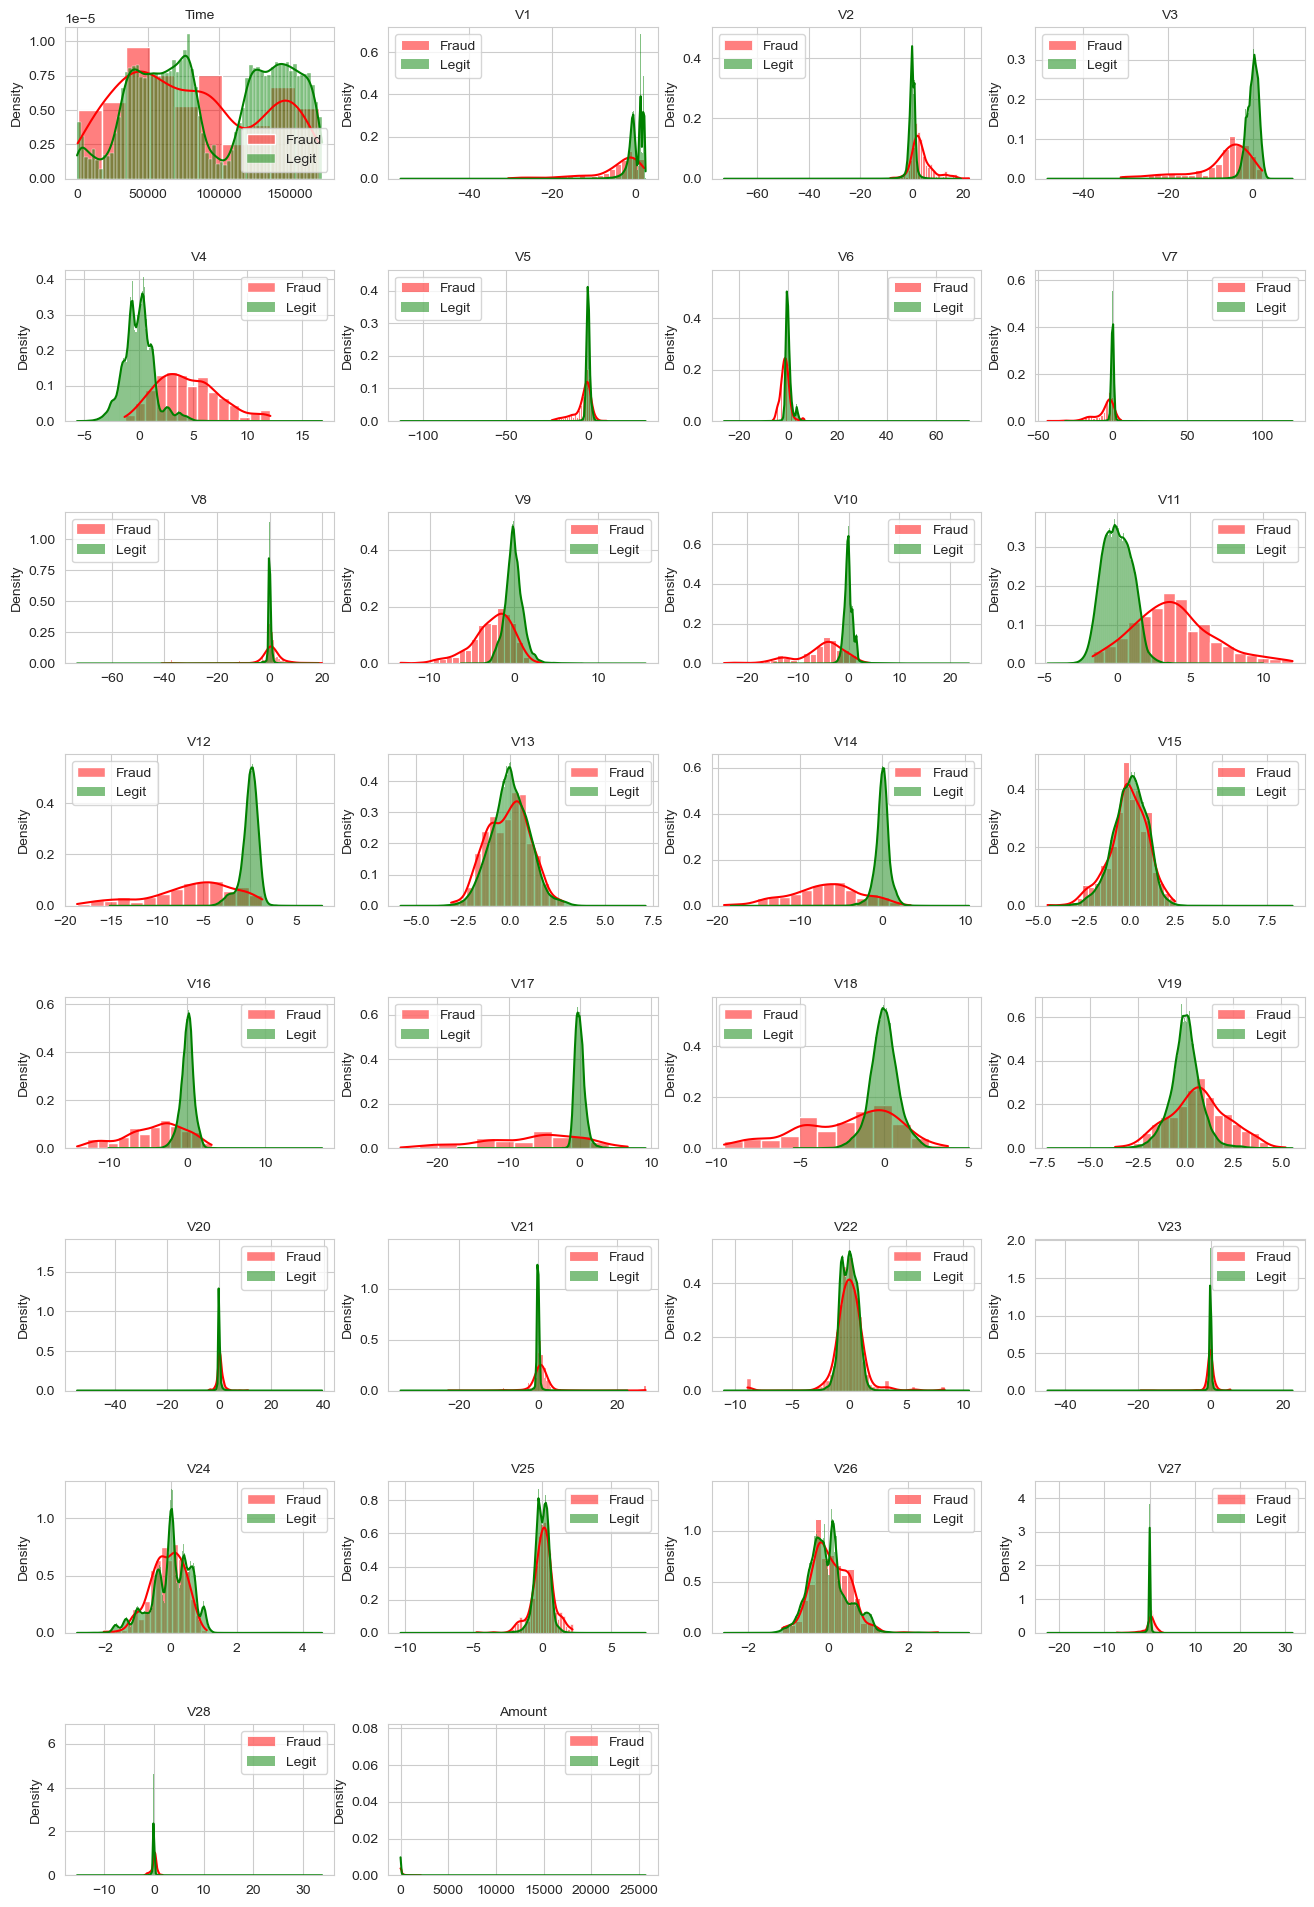

In [11]:
# Definimos solo las variables predictoras
features = df.drop("Class", axis=1).columns
n_features = len(features)

# Calculamos tamaño óptimo de la grilla (por ejemplo, 4 columnas)
cols = 4
rows = int(np.ceil(n_features / cols))

# Estilo general
sns.set_style("whitegrid")
plt.figure(figsize=(cols * 4, rows * 3))
gs = gridspec.GridSpec(rows, cols)
gs.update(hspace=0.6)

# Recorremos cada variable
for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Histograma para fraude (Class==1)
    sns.histplot(df[df["Class"] == 1][f], kde=True, stat="density", color="red", alpha=0.5, label="Fraud", ax=ax)
    # Histograma para legítimo (Class==0)
    sns.histplot(df[df["Class"] == 0][f], kde=True, stat="density", color="green", alpha=0.5, label="Legit", ax=ax)
    ax.set_title(f, fontsize=10)
    ax.set_xlabel("")
    ax.legend()

plt.tight_layout()
plt.show()

<p><em><strong>Comentario: </strong>Estas visualizaciones nos ayudan a entender que variables pudieran ser las m&aacute;s importantes o claves para construir el modelo, inicialmente yo dir&iacute;a que v10, v11, v12, v14, v17 tendr&aacute;n un papel clave en el modelo.&nbsp;</em></p>

## 3. Preparación del conjunto de datos

Para este tipo de algoritmos es importante que todos los datos se encuentren en un rango similar, por lo tanto, podemos aplicar una función de escalado o normalización. Otra opción, es eliminar las características que no se encuentran en un rango similar siempre y cuando no sean muy influyentes para la predicción.

In [29]:
#Eliminamos las columnas time y amount
df = df.drop(["Time", "Amount"], axis=1)

## 4. División del conjunto de datos

In [30]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [31]:
#Removemos la variable objetivo del dataset
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

<p><em><strong>Comentario: </strong>Dividimos el dataset en tres subconjuntos: a) Entrenamiento, b) Validaci&oacute;n, c) Prueba.</em></p>

## 5. Redes Neuronales Artificiales 

### Aplicamos selección de características con Random Forest

In [32]:
# Utilizamos Random Forest para realizar selección de características
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [33]:
# Seleccionamos las características más importantes
feature_importances = {name: score for name, score in zip(list(X_train), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(10)

V17    0.243084
V14    0.132483
V12    0.093218
V11    0.066528
V16    0.066408
V10    0.059194
V18    0.034266
V9     0.030143
V4     0.025466
V7     0.020946
dtype: float64

In [34]:
# Reducimos el conjunto de datos a las 20 características más importantes
features = list(feature_importances_sorted.head(20).index)
X_train_select = X_train[features].copy()
X_val_select = X_val[features].copy()
X_test_select = X_test[features].copy()
X_train_select

,V17,V14,V12,V11,V16,V10,V18,V9,V4,V7,V1,V15,V20,V6,V21,V3,V26,V8,V27,V5
164406,-1.209313,-0.115675,-0.589246,-1.850664,0.954582,-0.975273,0.640636,0.226930,-0.779271,0.176700,-1.509348,0.337068,0.502244,-0.250687,0.369591,1.089287,0.288080,0.211197,-0.023211,1.213151
220383,-0.685169,-0.505054,-0.440400,-0.752344,0.794032,0.919355,-0.031408,-0.965050,2.972199,0.497715,-0.855208,-0.981423,-0.358988,0.195791,1.074965,2.563111,-0.011914,-0.915033,-0.087454,-0.187680
49922,-1.121411,-0.439746,-0.361721,-0.942655,1.077567,-0.094516,0.342143,-0.612186,0.455518,-0.402337,-1.082417,-0.652224,-0.028980,4.381102,-0.069963,1.375652,-0.119972,1.227511,-0.072594,2.471959
181642,-0.107078,0.565399,-0.035721,-1.144233,-0.494280,0.107004,-0.658594,0.450298,0.672408,0.612810,1.898722,-0.368894,-0.082106,-1.267347,0.015111,-1.771837,0.378225,-0.441070,-0.106042,0.115019
210715,0.349047,-0.433966,0.355078,1.124602,0.505890,-0.179247,0.251416,0.375881,0.354859,0.016307,2.019857,-0.397238,-0.218017,-0.688151,-0.312851,-1.623959,0.146084,-0.043346,-0.072767,0.291940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.356782,0.600937,0.777009,1.585195,0.239566,0.079128,-0.410923,-0.114199,0.461596,-0.165254,1.173488,0.658885,-0.157534,-0.213165,-0.186027,0.490512,0.109235,0.119221,-0.020922,-0.296377
259178,-0.462528,0.384625,0.346437,-0.421422,0.057999,-0.654029,-0.063197,0.400697,-1.241113,-0.466107,-0.775981,0.785702,-0.295730,3.912076,0.037078,-1.142399,-0.770941,1.360620,0.066006,1.940358
131932,-0.539887,-0.019493,0.022804,-0.382362,-0.144778,-0.212753,-0.068375,-0.491303,0.485774,1.076640,-0.146609,0.690200,0.007155,-0.815198,0.052649,1.524591,-0.398467,-0.395316,-0.121139,0.349308
146867,-0.396148,0.927786,0.570400,-0.418939,0.426113,-0.027572,-0.946837,0.580199,-3.798905,-0.471769,-2.948638,-0.090065,0.417396,2.727695,-0.332759,-2.521201,0.426309,2.217537,0.496912,1.866302


<p><em><strong>Comentario:</strong> Usamos random forest para sustraer las caracter&iacute;sticas m&aacute;s importantes, en este caso usamos las 20 principales para construir el&nbsp; modelo</em></p>

**Entrenamiento del algoritmo RNA**

In [104]:
# Entrenamiento del algoritmo
model1 = models.Sequential()

model1 = models.Sequential()
model1.add(layers.Dense(128, activation='relu', input_shape=(X_train_select.shape[1],)))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(16, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [105]:
# Resumen de las capas del modelo
model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,569 (53.00 KB)

 Trainable params: 13,569 (53.00 KB)

 Non-trainable params: 0 (0.00 B)

<p><strong>Dise&ntilde;o y Entrenamiento del Modelo de Red Neuronal</strong></p>
<p data-start="175" data-end="338">Se construy&oacute; un modelo de red neuronal profunda utilizando la API secuencial de Keras. La arquitectura consta de cinco capas densas con la siguiente configuraci&oacute;n:</p>
<ul data-start="340" data-end="664">
<li data-start="340" data-end="407">
<p data-start="342" data-end="407"><strong data-start="342" data-end="362">Capa de entrada:</strong> 128 neuronas con funci&oacute;n de activaci&oacute;n ReLU.</p>
</li>
<li data-start="408" data-end="458">
<p data-start="410" data-end="458"><strong data-start="410" data-end="428">Capa oculta 1:</strong> 64 neuronas, activaci&oacute;n ReLU.</p>
</li>
<li data-start="459" data-end="509">
<p data-start="461" data-end="509"><strong data-start="461" data-end="479">Capa oculta 2:</strong> 32 neuronas, activaci&oacute;n ReLU.</p>
</li>
<li data-start="510" data-end="560">
<p data-start="512" data-end="560"><strong data-start="512" data-end="530">Capa oculta 3:</strong> 16 neuronas, activaci&oacute;n ReLU.</p>
</li>
<li data-start="561" data-end="664">
<p data-start="563" data-end="664"><strong data-start="563" data-end="582">Capa de salida:</strong> 1 neurona con activaci&oacute;n sigmoide, adecuada para tareas de clasificaci&oacute;n binaria.</p>
</li>
</ul>
<p data-start="666" data-end="925">El modelo se compil&oacute; utilizando el optimizador <strong data-start="713" data-end="721">Adam</strong>, con la funci&oacute;n de p&eacute;rdida <strong data-start="749" data-end="772">binary_crossentropy</strong>, adecuada para problemas de clasificaci&oacute;n binaria. Como m&eacute;trica principal de evaluaci&oacute;n durante el entrenamiento se utiliz&oacute; la <strong data-start="900" data-end="924">precisi&oacute;n (accuracy)</strong></p>
<p data-start="646" data-end="945">En total, el modelo cuenta con 13,569 par&aacute;metros entrenables, y no hay par&aacute;metros no entrenables, se caracteriza por una estructura progresivamente reducida, lo que puede ayudar a evitar el sobreajuste y a mejorar la generalizaci&oacute;n</p>

In [106]:
# Entrenamos el algoritmo
history = model1.fit(X_train_select,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_val_select, y_val))

Epoch 1/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - acc: 0.9933 - loss: 0.0296 - val_acc: 0.9994 - val_loss: 0.0034
Epoch 2/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - acc: 0.9994 - loss: 0.0031 - val_acc: 0.9994 - val_loss: 0.0032
Epoch 3/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - acc: 0.9994 - loss: 0.0031 - val_acc: 0.9994 - val_loss: 0.0030
Epoch 4/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - acc: 0.9994 - loss: 0.0026 - val_acc: 0.9994 - val_loss: 0.0032
Epoch 5/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - acc: 0.9993 - loss: 0.0029 - val_acc: 0.9994 - val_loss: 0.0034
Epoch 6/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - acc: 0.9994 - loss: 0.0030 - val_acc: 0.9993 - val_loss: 0.0037
Epoch 7/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - acc: 0.9995 - loss: 0.0021 - val_acc: 0.9993 - val_loss: 0.0041
Epoch 8/10
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - acc: 0.9994 - loss: 0.0026 - val_acc: 0.9991 - val_loss: 0.0037
Epoch 9/10
2671/2671 ━━━━━━━━━━━━

**Predicción con el conjunto de datos de Validación**

In [107]:
# Predicción con el conjunto de datos de pruebas
pred = model1.predict(X_val_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [108]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.86      0.85      0.85        98

    accuracy                           1.00     56961
   macro avg       0.93      0.92      0.93     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [109]:
# Predicción con el conjunto de datos de pruebas
pred = model1.predict(X_test_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [110]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.80      0.86      0.83        93

    accuracy                           1.00     56962
   macro avg       0.90      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="46" data-end="229"><strong>Conclusi&oacute;n</strong>:&nbsp;El modelo de red neuronal ha demostrado un alto rendimiento tanto en el conjunto de validaci&oacute;n como en el de prueba, con una exactitud general del 100% en ambos casos.</p>
<p data-start="231" data-end="362">Sin embargo, debido al desbalance de clases, es m&aacute;s relevante centrarse en los resultados de la <strong data-start="327" data-end="338">clase 1</strong> (la clase minoritaria):</p>
<ul data-start="364" data-end="752">
<li data-start="364" data-end="574">
<p data-start="366" data-end="574">En <strong data-start="369" data-end="383">validaci&oacute;n</strong>, se obtuvo una <strong data-start="399" data-end="420">precisi&oacute;n del 86%</strong> y un <strong data-start="426" data-end="444">recall del 85%</strong>, lo que indica que el modelo es capaz de identificar correctamente la mayor&iacute;a de los casos positivos, con pocos falsos positivos.</p>
</li>
<li data-start="575" data-end="752">
<p data-start="577" data-end="752">En <strong data-start="580" data-end="590">prueba</strong>, el modelo mantuvo un <strong data-start="613" data-end="631">recall del 86%</strong>, y una <strong data-start="639" data-end="660">precisi&oacute;n del 80%</strong>, lo cual refleja una buena capacidad de generalizaci&oacute;n y detecci&oacute;n de la clase minoritaria.</p>
</li>
</ul>
<p data-start="754" data-end="998">Estos resultados indican que el modelo no solo se ajusta bien a los datos de entrenamiento, sino que tambi&eacute;n mantiene un desempe&ntilde;o s&oacute;lido en nuevos datos, siendo adecuado para tareas donde es importante detectar correctamente la clase positiva.</p>

### Aplicamos selección de características que visualmente tengan mayor impacto y hagan Match con RandomForest

In [42]:
X_train_reduced = X_train[["V11","V12","V14","V17"]].copy()
X_val_reduced = X_val[["V11","V12","V14","V17"]].copy()
X_test_reduced = X_test[["V11","V12","V14","V17"]].copy()

<p data-start="46" data-end="229"><em><strong>Comentario: </strong>Elegimos las 4 m&aacute;s importantes que curiosamente entran en el conjunto que identificamos visualmente.&nbsp;</em></p>

**Entrenamiento del algoritmo RNA**

In [111]:
# Definición de la arquitectura de la red neuronal
model2 = models.Sequential()
model2.add(layers.Dense(128, activation='relu', input_shape=(X_train_reduced.shape[1],)))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

C:\Users\luise\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [112]:
# Resumen de las capas del modelo
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

<p data-start="46" data-end="229"><em><strong>Comentario: </strong>Se eligieron las 4 caracter&iacute;sticas m&aacute;s importantes , se cambi&oacute; el par&aacute;metro epochs=40&nbsp; y tiene el mismo dise&ntilde;o de red neuronal que el anterior.</em></p>

In [113]:
# Entrenamos el modelo
history = model2.fit(X_train_reduced,
                   y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(X_val_reduced, y_val))

Epoch 1/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.9984 - loss: 0.0796 - val_acc: 0.9992 - val_loss: 0.0041
Epoch 2/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0040 - val_acc: 0.9994 - val_loss: 0.0035
Epoch 3/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.9992 - loss: 0.0045 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 4/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9993 - loss: 0.0041 - val_acc: 0.9993 - val_loss: 0.0035
Epoch 5/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.9994 - loss: 0.0033 - val_acc: 0.9993 - val_loss: 0.0034
Epoch 6/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0038 - val_acc: 0.9992 - val_loss: 0.0038
Epoch 7/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9993 - loss: 0.0034 - val_acc: 0.9993 - val_loss: 0.0036
Epoch 8/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - acc: 0.9994 - loss: 0.0037 - val_acc: 0.9993 - val_loss: 0.0036
Epoch 9/40
334/334 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - ac

**Predicción con el conjunto de datos de Validación**

In [114]:
# Predicción con el conjunto de datos de pruebas
pred = model2.predict(X_val_reduced) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [115]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.84      0.76      0.80        98

    accuracy                           1.00     56961
   macro avg       0.92      0.88      0.90     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [116]:
# Predicción con el conjunto de datos de pruebas
pred = model2.predict(X_test_reduced) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [118]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.81      0.81      0.81        93

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="78" data-end="447"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p data-start="78" data-end="447">Se entren&oacute; un nuevo modelo de red neuronal con el mismo dise&ntilde;o, pero utilizando solo 4 caracter&iacute;sticas y 40 epochs. Los resultados muestran que, en validaci&oacute;n, la clase minoritaria (Clase 1) obtuvo una precisi&oacute;n de 0.84 y un recall de 0.76, con un F1-score de 0.80. En la prueba, la precisi&oacute;n y recall para la clase 1 fueron ambos 0.81, con un F1-score tambi&eacute;n de 0.81.</p>
<p data-start="449" data-end="848">Comparando con el modelo anterior que usaba m&aacute;s caracter&iacute;sticas y un mayor n&uacute;mero de epochs, se observa que el rendimiento <strong>para la clase 1 disminuy&oacute; ligeramente en recall (antes 0.85 vs ahora 0.76 en validaci&oacute;n) y en F1-score (antes 0.85 vs ahora 0.80)</strong>. Sin embargo, el nuevo modelo mantiene un accuracy global alto y m&eacute;trica balanceadas, pero con menor capacidad para detectar la clase minoritaria.</p>
<p data-start="850" data-end="1201">En conclusi&oacute;n, <strong>el modelo anterior con m&aacute;s caracter&iacute;sticas y m&aacute;s epochs es mejor para clasificar correctamente la clase minoritaria</strong>, que es usualmente la m&aacute;s importante en problemas de clasificaci&oacute;n desbalanceada. Por tanto, se recomienda mantener el uso de m&aacute;s caracter&iacute;sticas y un entrenamiento m&aacute;s prolongado para mejorar el desempe&ntilde;o en esta clase.</p>

## 6.- Elegir Mejor Modelo y optimizar

### Optimizar el modelo con Optuna

In [46]:
import optuna
from tensorflow.keras import Input

def objective(trial):
    # Sugerir hiperparámetros para cada capa
    units1 = trial.suggest_int('units1', 64, 256, step=32)
    units2 = trial.suggest_int('units2', 32, 128, step=16)
    units3 = trial.suggest_int('units3', 16, 64, step=8)
    units4 = trial.suggest_int('units4', 8, 32, step=8)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    model = models.Sequential()
    model.add(Input(shape=(X_train_select.shape[1],)))  # Aquí la corrección
    model.add(layers.Dense(units1, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units2, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units3, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units4, activation=activation))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train_select, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=512,
                        verbose=0)

    val_acc = max(history.history['val_accuracy'])
    return val_acc


In [47]:
# Crear estudio y ejecutar búsqueda
study = optuna.create_study(study_name="mi_estudio", direction='maximize')
study.optimize(objective, n_trials=30)


[I 2025-05-29 16:07:01,098] A new study created in memory with name: mi_estudio
[I 2025-05-29 16:07:28,485] Trial 0 finished with value: 0.9994440674781799 and parameters: {'units1': 224, 'units2': 48, 'units3': 40, 'units4': 24, 'activation': 'relu', 'dropout_rate': 0.0792344281333075, 'lr': 0.00020207846162124255}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-29 16:07:47,494] Trial 1 finished with value: 0.9994440674781799 and parameters: {'units1': 96, 'units2': 80, 'units3': 16, 'units4': 32, 'activation': 'relu', 'dropout_rate': 0.18023387299379046, 'lr': 0.003223437193423353}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-29 16:08:13,734] Trial 2 finished with value: 0.9994440674781799 and parameters: {'units1': 192, 'units2': 96, 'units3': 56, 'units4': 32, 'activation': 'tanh', 'dropout_rate': 0.4082962485774193, 'lr': 0.0004612145622757574}. Best is trial 0 with value: 0.9994440674781799.
[I 2025-05-29 16:08:37,899] Trial 3 finished with value: 0.999

In [48]:
print("Mejores hiperparámetros:", study.best_params)

Mejores hiperparámetros: {'units1': 160, 'units2': 48, 'units3': 32, 'units4': 24, 'activation': 'tanh', 'dropout_rate': 0.0565099786948637, 'lr': 0.0001557292560449566}


Para reconstruir el modelo con esos hiperparámetros (ideal para usarlo después):

In [49]:
best_params = study.best_params

best_model = models.Sequential()
best_model.add(layers.Dense(best_params['units1'], activation=best_params['activation'], input_shape=(X_train_select.shape[1],)))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units2'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units3'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(best_params['units4'], activation=best_params['activation']))
best_model.add(layers.Dropout(best_params['dropout_rate']))
best_model.add(layers.Dense(1, activation='sigmoid'))

optimizer = optimizers.Adam(learning_rate=best_params['lr'])
best_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\luise\anaconda3\envs\Pruebas\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
# Resumen de las capas del modelo
best_model.summary()

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 160)            │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_280 (Dropout)           │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 48)             │         7,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_281 (Dropout)           │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_282 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 24)             │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_283 (Dropout)           │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,421 (157.90 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,948 (105.27 KB)

Entrena nuevamente este modelo (opcional pero recomendado para asegurar estabilidad):

In [58]:
best_model.fit(X_train_select, y_train, epochs=10, batch_size=512, validation_split=0.2)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9992 - loss: 0.0041 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9992 - loss: 0.0040 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9996 - val_loss: 0.0026
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.9995 - val_loss: 0.0025
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.

<p data-start="78" data-end="447"><em><strong>Comentario:</strong> Este c&oacute;digo busca autom&aacute;ticamente los mejores valores para dos par&aacute;metros del modelo: el tama&ntilde;o del lote (batch_size) y el n&uacute;mero de &eacute;pocas (epochs). Para ello, prueba varias combinaciones de estos par&aacute;metros usando validaci&oacute;n cruzada, y selecciona la que obtiene el mejor resultado en la m&eacute;trica F1, que mide el equilibrio entre precisi&oacute;n y recall. Al final, muestra los mejores par&aacute;metros encontrados</em></p>

**Predicción con el conjunto de datos de Validación**

In [59]:
# Predicción con el conjunto de datos de pruebas
pred = best_model.predict(X_val_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [60]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.88      0.80      0.83        98

    accuracy                           1.00     56961
   macro avg       0.94      0.90      0.92     56961
weighted avg       1.00      1.00      1.00     56961



**Predicción con el conjunto de datos de Prueba**

In [61]:
# Predicción con el conjunto de datos de pruebas
pred = best_model.predict(X_test_select) 
y_pred = (pred > 0.5).astype("int32")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [62]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.85      0.82      0.84        93

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



<p data-start="1133" data-end="1300"><br /><strong>Conclusi&oacute;n:</strong></p>
<ul>
<li data-start="628" data-end="828">
<p data-start="630" data-end="828"><strong data-start="630" data-end="644">Precision:</strong> El modelo optimizado mejora la precisi&oacute;n en ambas fases (validaci&oacute;n y prueba), lo que significa que comete menos falsos positivos (predice menos veces que es Clase 1 cuando no lo es).</p>
</li>
<li data-start="829" data-end="1002">
<p data-start="831" data-end="1002"><strong data-start="831" data-end="842">Recall:</strong> El modelo original tiene mayor recall en validaci&oacute;n y prueba, es decir, detecta mejor los verdaderos positivos (m&aacute;s casos de Clase 1 detectados correctamente).</p>
</li>
<li data-start="1003" data-end="1105">
<p data-start="1005" data-end="1105"><strong data-start="1005" data-end="1018">F1-score:</strong> Ambos est&aacute;n bastante parejos, con una leve ventaja del modelo optimizado en la prueba.</p>
</li>
</ul>
<p data-start="1133" data-end="1300"><br />El <strong data-start="1136" data-end="1155">modelo original</strong> prioriza ligeramente el <strong data-start="1180" data-end="1190">recall</strong> (sensibilidad), mientras que el <strong data-start="1223" data-end="1244">modelo optimizado</strong> da m&aacute;s peso a la <strong data-start="1262" data-end="1275">precisi&oacute;n</strong>. Depende de tu objetivo:</p>
<ul data-start="1302" data-end="1538">
<li data-start="1302" data-end="1430">
<p data-start="1304" data-end="1430">&iquest;Te interesa <strong data-start="1317" data-end="1366">detectar la mayor cantidad posible de Clase 1</strong> (aunque haya m&aacute;s falsos positivos)? Usa el <strong data-start="1410" data-end="1429">modelo original</strong>.</p>
</li>
<li data-start="1431" data-end="1538">
<p data-start="1433" data-end="1538">&iquest;Te importa m&aacute;s <strong data-start="1449" data-end="1476">evitar falsos positivos</strong> (aunque se escape alguno real)? Usa el <strong data-start="1516" data-end="1537">modelo optimizado</strong>.</p>
</li>
</ul>

### Calculando  ROA y Precision-Recall curve

<p><strong>Comentario</strong>: Elegimos el original porque deseamos priorizar un poco m&aacute;s el Recall sin sacrificar tanto la precisi&oacute;n.</p>

In [ ]:
# Obtener probabilidades
y_probs = model1.predict(X_val_select).ravel()

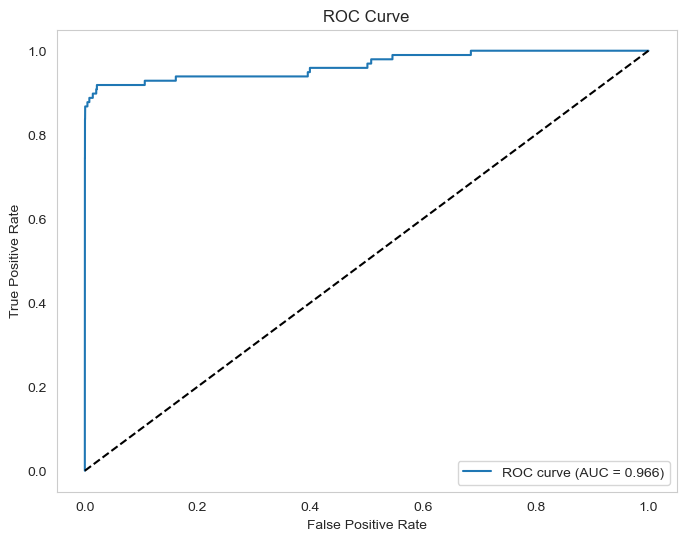

In [141]:
# Calcular FPR, TPR y umbrales
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc = roc_auc_score(y_val, y_probs)

# Graficar curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0,1], [0,1], 'k--')  # Línea diagonal (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

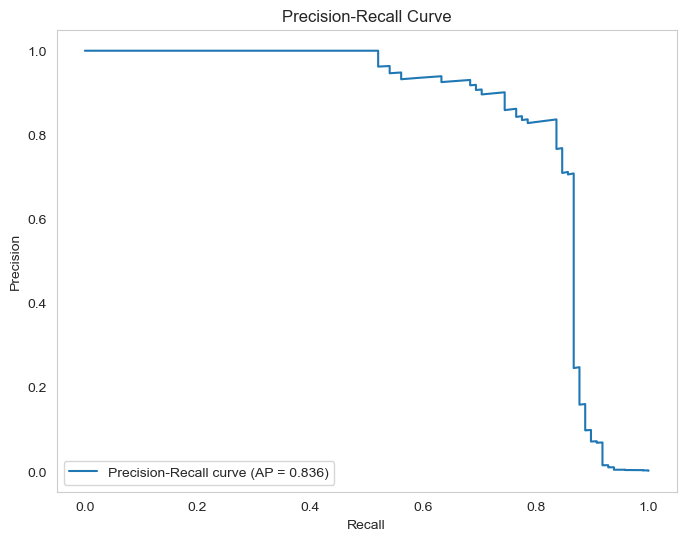

In [142]:
#Curva de Presicion Recall
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)
ap = average_precision_score(y_val, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

<p data-start="0" data-end="126">Las gr&aacute;ficas proporcionadas muestran el desempe&ntilde;o del modelo en t&eacute;rminos de discriminaci&oacute;n y precisi&oacute;n para la clase positiva:</p>
<ol data-start="128" data-end="639">
<li data-start="128" data-end="350">
<p data-start="131" data-end="350"><strong data-start="131" data-end="159">Curva ROC (AUC = 0.966):</strong> El modelo presenta una excelente capacidad para distinguir entre clases. Un AUC cercano a 1 indica que el modelo clasifica correctamente los positivos y negativos en la mayor&iacute;a de los casos.</p>
</li>
<li data-start="352" data-end="639">
<p data-start="355" data-end="639"><strong data-start="355" data-end="395">Curva Precision-Recall (AP = 0.836):</strong> El modelo mantiene un buen balance entre precisi&oacute;n y recall, lo cual es especialmente importante en contextos con clases desbalanceadas. Un AP (average precision) de 0.836 sugiere un buen desempe&ntilde;o general en la detecci&oacute;n de la clase positiva.</p>
</li>
</ol>
<p data-start="641" data-end="788">En resumen, ambas gr&aacute;ficas confirman que el modelo es eficaz en la detecci&oacute;n de la clase minoritaria, mostrando un rendimiento s&oacute;lido y confiable.</p>
<p>.</p>

### Buscando el mejor Threshold tomando como metrica F1

**Buscando el Mejor Threshold en los datos de validacion**

In [155]:
# Probabilidades predichas por el modelo
y_probs = model1.predict(X_val_select) 
# Buscar el mejor threshold para F1-score
best_thresh, best_f1 = find_best_threshold(y_val, y_probs)
# Usar ese threshold para predecir clases
print(f"Mejor threshold: {best_thresh:.2f} con F1-score: {best_f1:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Mejor threshold: 0.54 con F1-score: 0.8557


**Predicción con el conjunto de datos de Validacion**

In [156]:
y_pred = (y_probs >= best_thresh).astype(int)

In [157]:
print(classification_report(y_val, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56863
     Clase 1       0.86      0.85      0.86        98

    accuracy                           1.00     56961
   macro avg       0.93      0.92      0.93     56961
weighted avg       1.00      1.00      1.00     56961



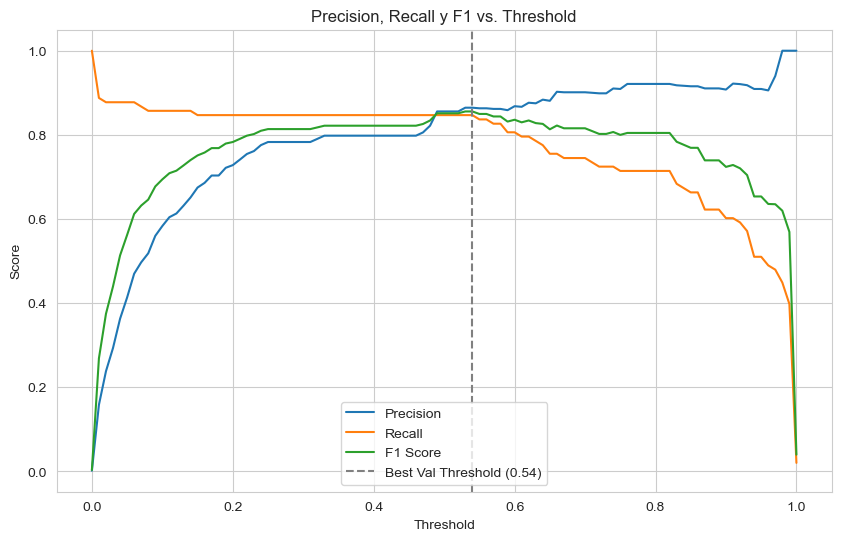

In [159]:
#Representar graficamente el threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision_scores.append(precision_score(y_val, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_val, y_pred, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(0.54, color='gray', linestyle='--', label='Best Val Threshold (0.54)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


**Buscando el Mejor Threshold en los datos de prueba**

In [160]:
# Probabilidades predichas por el modelo
y_probs = model1.predict(X_test_select)
# Buscar el mejor threshold para F1-score
best_thresh2, best_f1 = find_best_threshold(y_test, y_probs)
# Usar ese threshold para predecir clases
print(f"Mejor threshold: {best_thresh2:.2f} con F1-score: {best_f1:.4f}")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Mejor threshold: 0.58 con F1-score: 0.8404


**Predicción con el conjunto de datos de Prueba**

In [161]:
y_pred = (y_probs >= best_thresh2).astype(int)

In [162]:
print(classification_report(y_test, y_pred, target_names=["Clase 0", "Clase 1"]))

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00     56869
     Clase 1       0.83      0.85      0.84        93

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



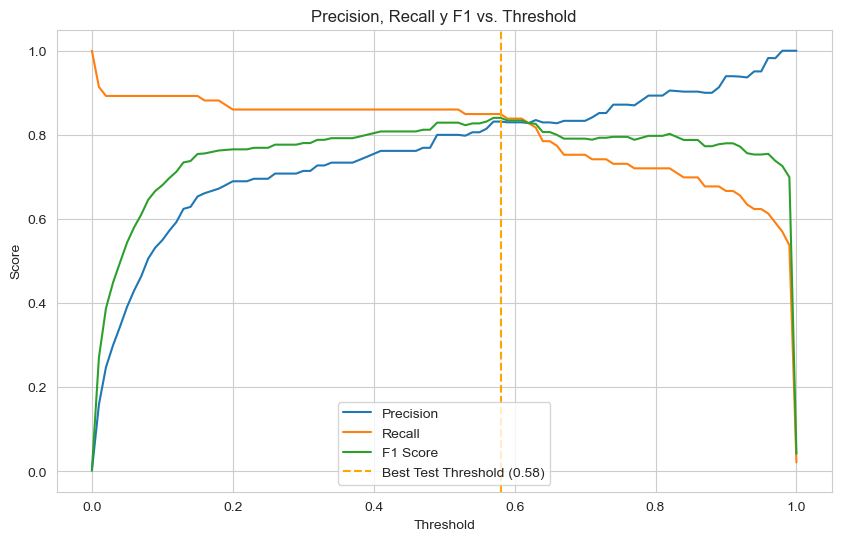

In [163]:
#Representar graficamente el threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred = (y_probs >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(0.58, color='orange', linestyle='--', label='Best Test Threshold (0.58)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


<p data-start="0" data-end="403"><strong>Conclusi&oacute;n:&nbsp;</strong></p>
<p data-start="0" data-end="403">La selecci&oacute;n de los thresholds de 0.54 para validaci&oacute;n y 0.58 para prueba permiti&oacute; optimizar el F1-score para la clase minoritaria (Clase 1), logrando un equilibrio adecuado entre precisi&oacute;n y recall. En ambos conjuntos no vistos, el desempe&ntilde;o fue consistente, manteniendo una alta precisi&oacute;n (&ge; 0.83) y un recall competitivo (&ge; 0.85), lo que indica que el modelo es robusto frente a cambios en los datos.</p>
<p data-start="405" data-end="581">Este ajuste fino del umbral de decisi&oacute;n <strong>mejora la capacidad del modelo para identificar correctamente los casos positivos sin sacrificar la calidad general de las predicciones</strong></p>
<p>.</p>

## 7.- Guardar Modelo para uso posterior

In [165]:
import joblib

joblib.dump(model1, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']